In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [3]:
# download the data

df_01 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-01.parquet')
df_02 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-02.parquet')
df_03 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-03.parquet')
df_04 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-04.parquet')
df_05 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-05.parquet')
df_06 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-06.parquet')
df_07 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-07.parquet')
df_08 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-08.parquet')
df_09 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-09.parquet')
df_10 = pd.read_parquet('//kaggle/input/nyc-taxi/yellow_tripdata_2022-10.parquet')
df_11 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-11.parquet')
df_12 = pd.read_parquet('/kaggle/input/nyc-taxi/yellow_tripdata_2022-12.parquet')

In [4]:
# converting the format

dfs = [df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12]
float_columns = ['trip_distance', 'RatecodeID', 'fare_amount', 'extra', 'mta_tax',
                 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
int_columns = ['VendorID', 'PULocationID', 'DOLocationID', 'payment_type', 'passenger_count']
dt_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

for df in dfs:
  df.fillna(0, inplace=True)
  df[float_columns] = df[float_columns].astype('float32')
  df[int_columns] = df[int_columns].astype('uint16')

In [5]:
# stacking the datasets together

df = pd.concat(dfs, ignore_index=True)

# deleting the unnecessary dataframes

for df_i in dfs:
  del df_i

In [6]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,39656098.000,39656098,39656098,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000,39656098.000
mean,1.722,2022-07-05 04:04:16.211669,2022-07-05 04:57:46.055587,1.353,5.959,1.375,164.866,162.575,1.190,10.363,1.008,0.489,7.235,0.536,0.316,21.671,2.203,0.094
min,1.000,2001-01-01 00:03:14,2001-01-01 00:34:17,0.000,0.000,0.000,1.000,1.000,0.000,-133391416.000,-22.180,-0.550,-410.000,-99.990,-1.000,-2567.800,-2.500,-1.250
25%,1.000,2022-04-07 21:59:21,2022-04-07 22:16:12,1.000,1.100,1.000,132.000,113.000,1.000,7.000,0.000,0.500,0.930,0.000,0.300,12.300,2.500,0.000
50%,2.000,2022-07-01 06:36:25.500000,2022-07-01 06:54:53.500000,1.000,1.900,1.000,162.000,162.000,1.000,10.500,0.500,0.500,2.160,0.000,0.300,15.960,2.500,0.000
75%,2.000,2022-10-04 20:17:12,2022-10-04 20:30:44,1.000,3.560,1.000,234.000,234.000,1.000,16.500,2.500,0.500,3.360,0.000,0.300,23.160,2.500,0.000
max,6.000,2023-04-18 14:30:05,2023-04-18 23:30:39,9.000,389678.469,99.000,265.000,265.000,5.000,401092.312,33.500,25.480,133391360.000,911.870,1.000,401095.625,2.750,1.250
std,0.481,NaN,NaN,0.980,599.191,5.699,65.311,70.231,0.519,22328.299,1.263,0.094,22328.084,2.043,0.129,96.374,0.848,0.333


In [7]:
# trip duration

df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df.drop('tpep_dropoff_datetime', axis=1, inplace=True)

In [8]:
# drop irrelevant years

df['year'] = df['tpep_pickup_datetime'].apply(lambda x: x.year)
df.drop(df[df['year'] != 2022].index, axis=0, inplace=True)
df.drop('year', axis=1, inplace=True)

In [9]:
# additional features from timestamps

df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['month'] = df['tpep_pickup_datetime'].dt.month
df['day_of_year'] = df['tpep_pickup_datetime'].dt.dayofyear
df['week'] = df['tpep_pickup_datetime'].apply(lambda x: x.isocalendar()[1])

american_holidays = calendar().holidays()
df['is_holiday'] = df['tpep_pickup_datetime'].dt.date.isin(american_holidays)

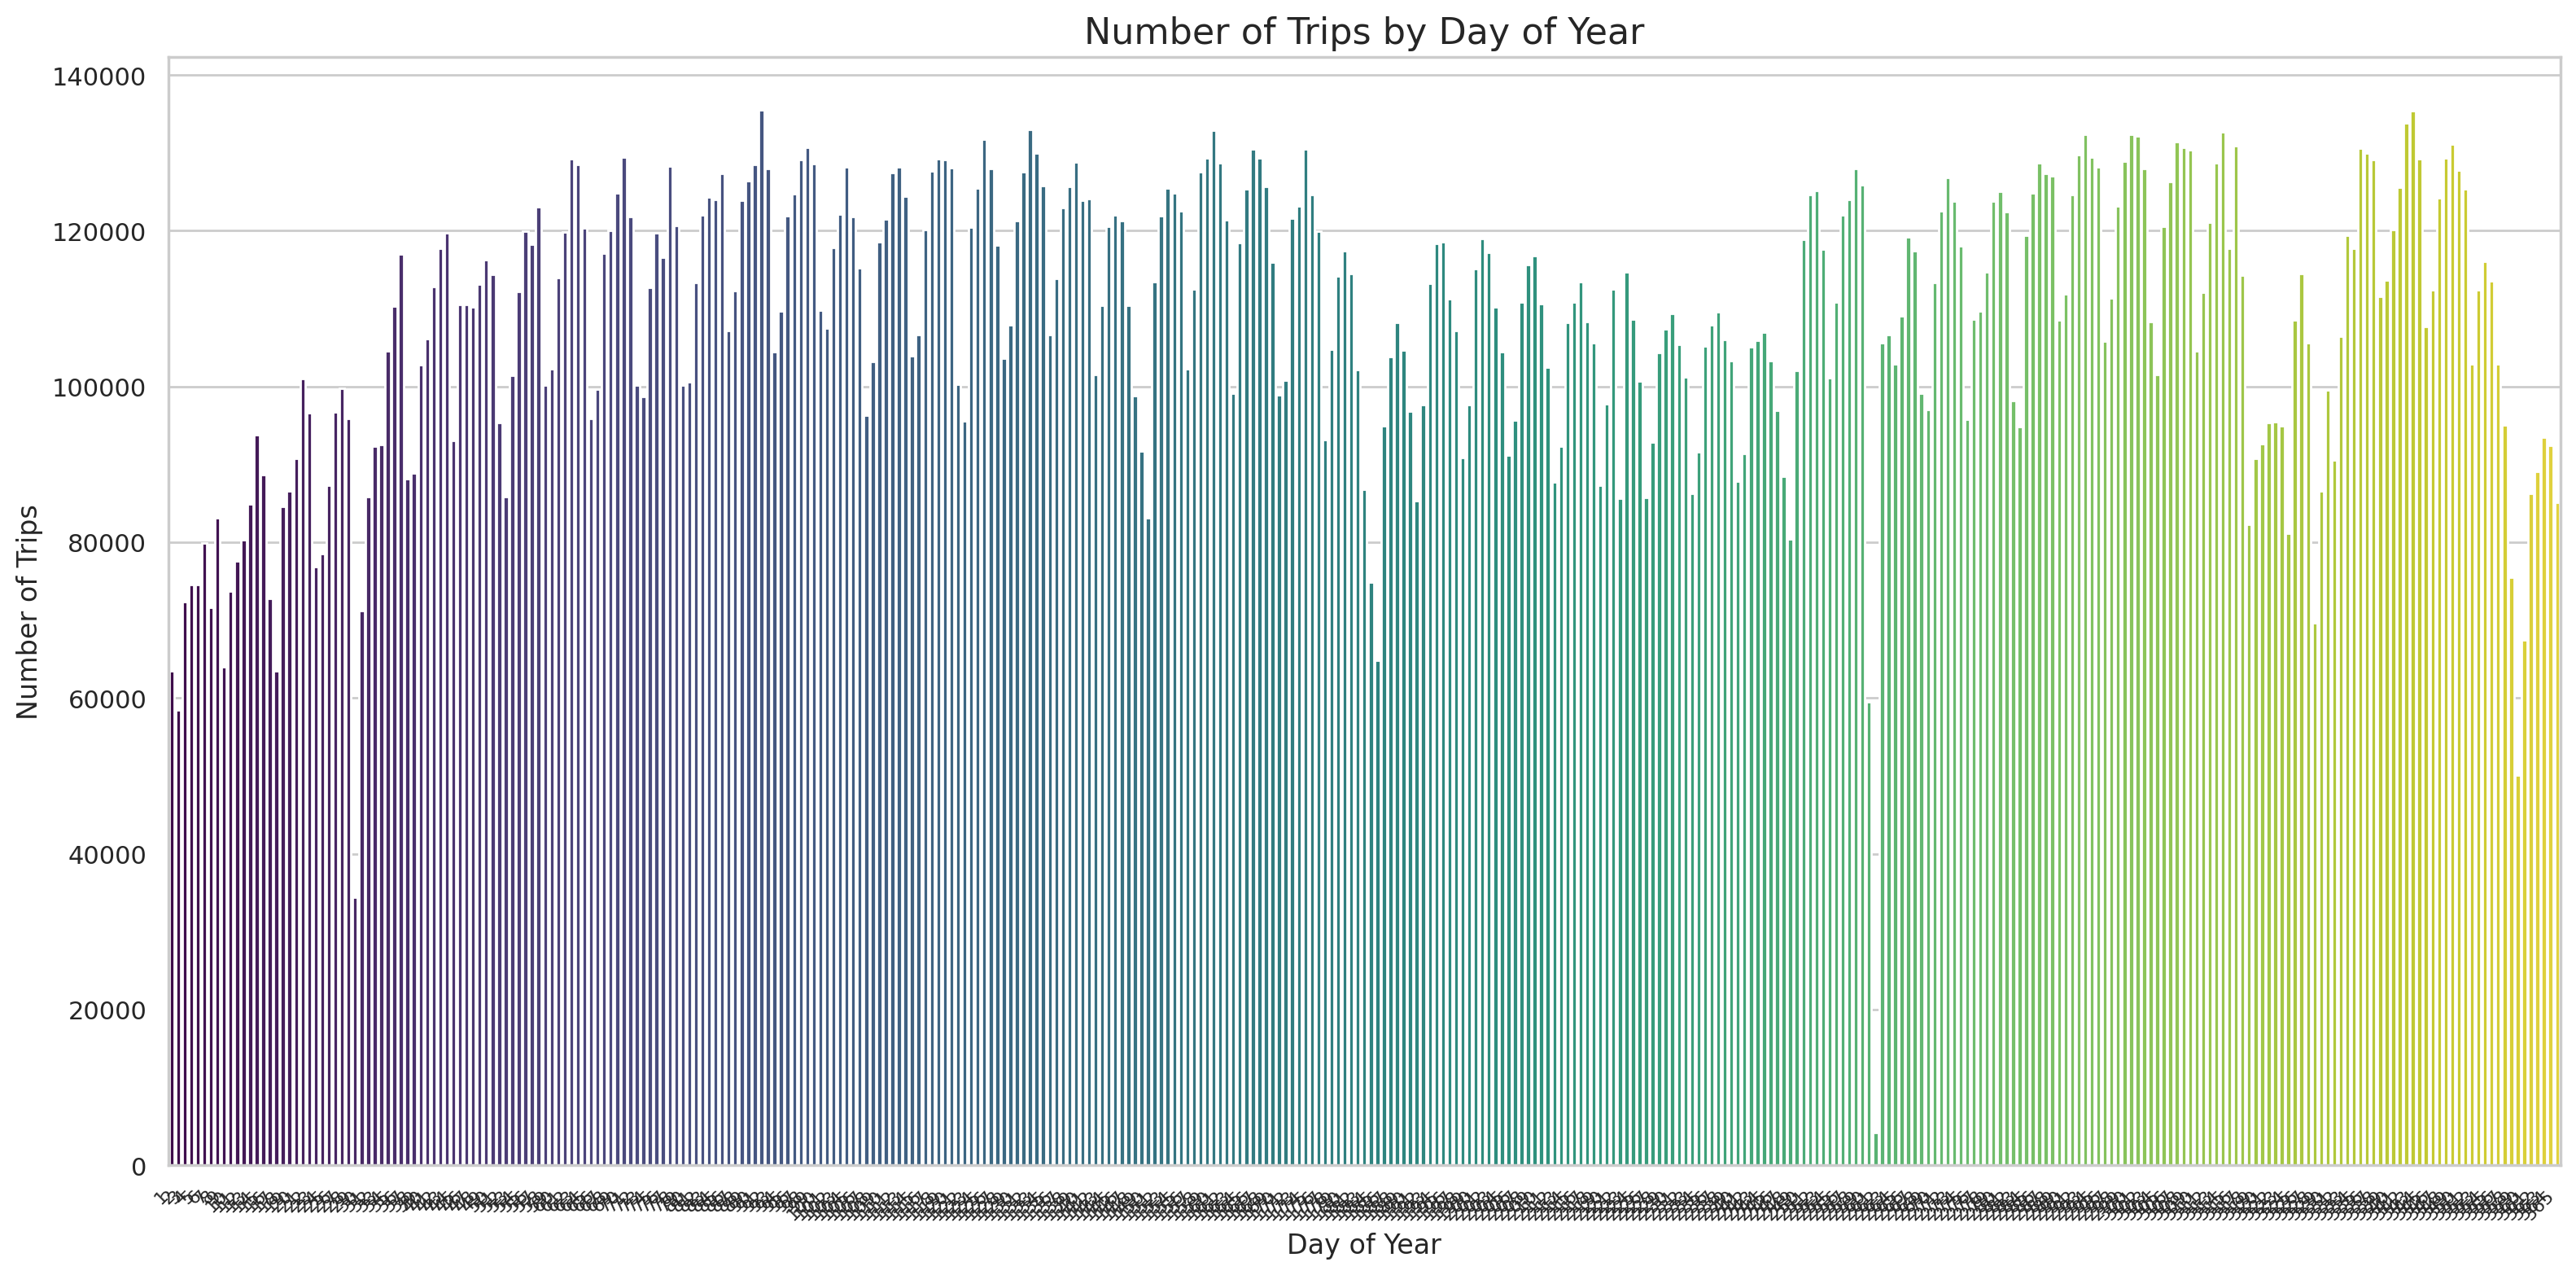

In [11]:
# number of trips vs day of year
plt.figure(figsize=(16, 8))
ax = sns.countplot(x=df['day_of_year'], palette='viridis')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)

plt.title('Number of Trips by Day of Year', fontsize=16)
plt.xlabel('Day of Year')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

In [12]:
df['day_of_year'].value_counts()

day_of_year
91     135560
343    135397
342    133862
132    133017
160    132859
        ...  
260     59501
2       58421
359     50109
29      34388
261      4229
Name: count, Length: 365, dtype: int64

<Figure size 1000x600 with 0 Axes>

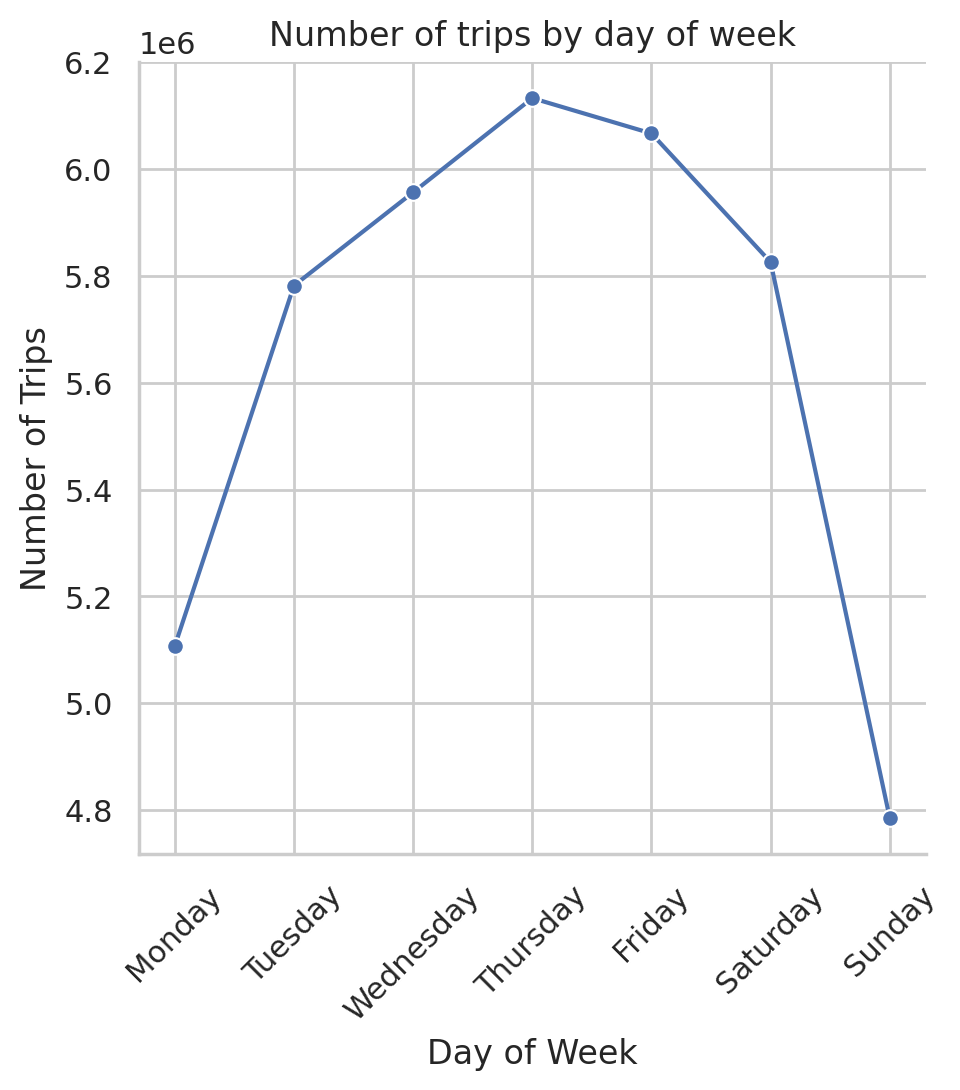

In [11]:
# number of trips vs day of week

# Count the number of trips for each day of the week
trip_counts = df['day_of_week'].value_counts().sort_index()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'day_of_week': trip_counts.index, 'trip_count': trip_counts.values})

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_df['day_of_week'] = pd.Categorical(plot_df['day_of_week'], categories=days_order, ordered=True)

# Create the plot using seaborn
plt.figure(figsize=(10, 6))
plot = sns.relplot(x='day_of_week', y='trip_count', kind='line', data=plot_df, marker='o')

# Set plot labels and title
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.title('Number of trips by day of week')
plt.xticks(rotation=45)

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

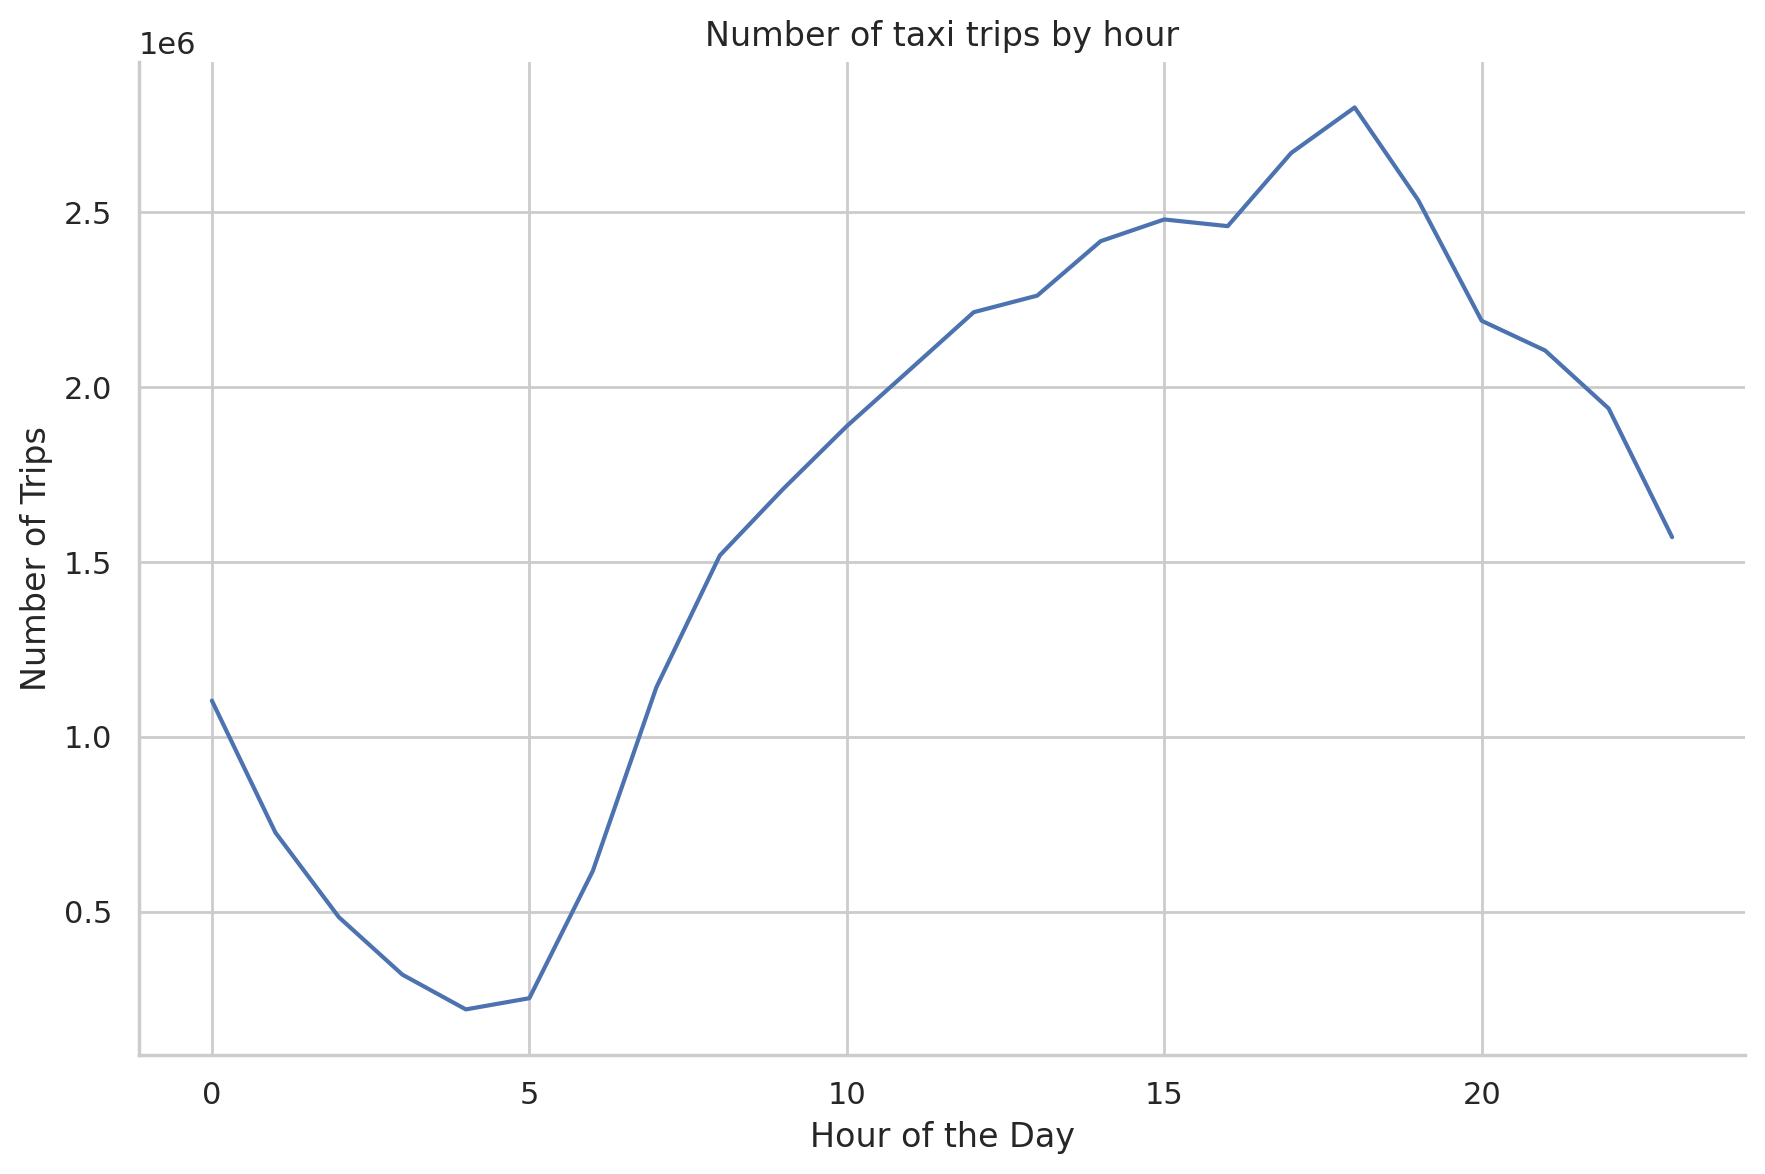

In [12]:
# number of trips vs hour

# Count the number of trips for each hour
hourly_counts = df['pickup_hour'].value_counts().sort_index()

# Create a DataFrame from the counts
hourly_df = pd.DataFrame({'Hour': hourly_counts.index, 'Trips': hourly_counts.values})

# Set the plotting style
sns.set(style="whitegrid")

# Create the relplot
plt.figure(figsize=(10, 6))
plot = sns.relplot(x='Hour', y='Trips', kind='line', data=hourly_df, sort=True, height=6, aspect=1.5)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Number of Trips', title='Number of taxi trips by hour')

# Display the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

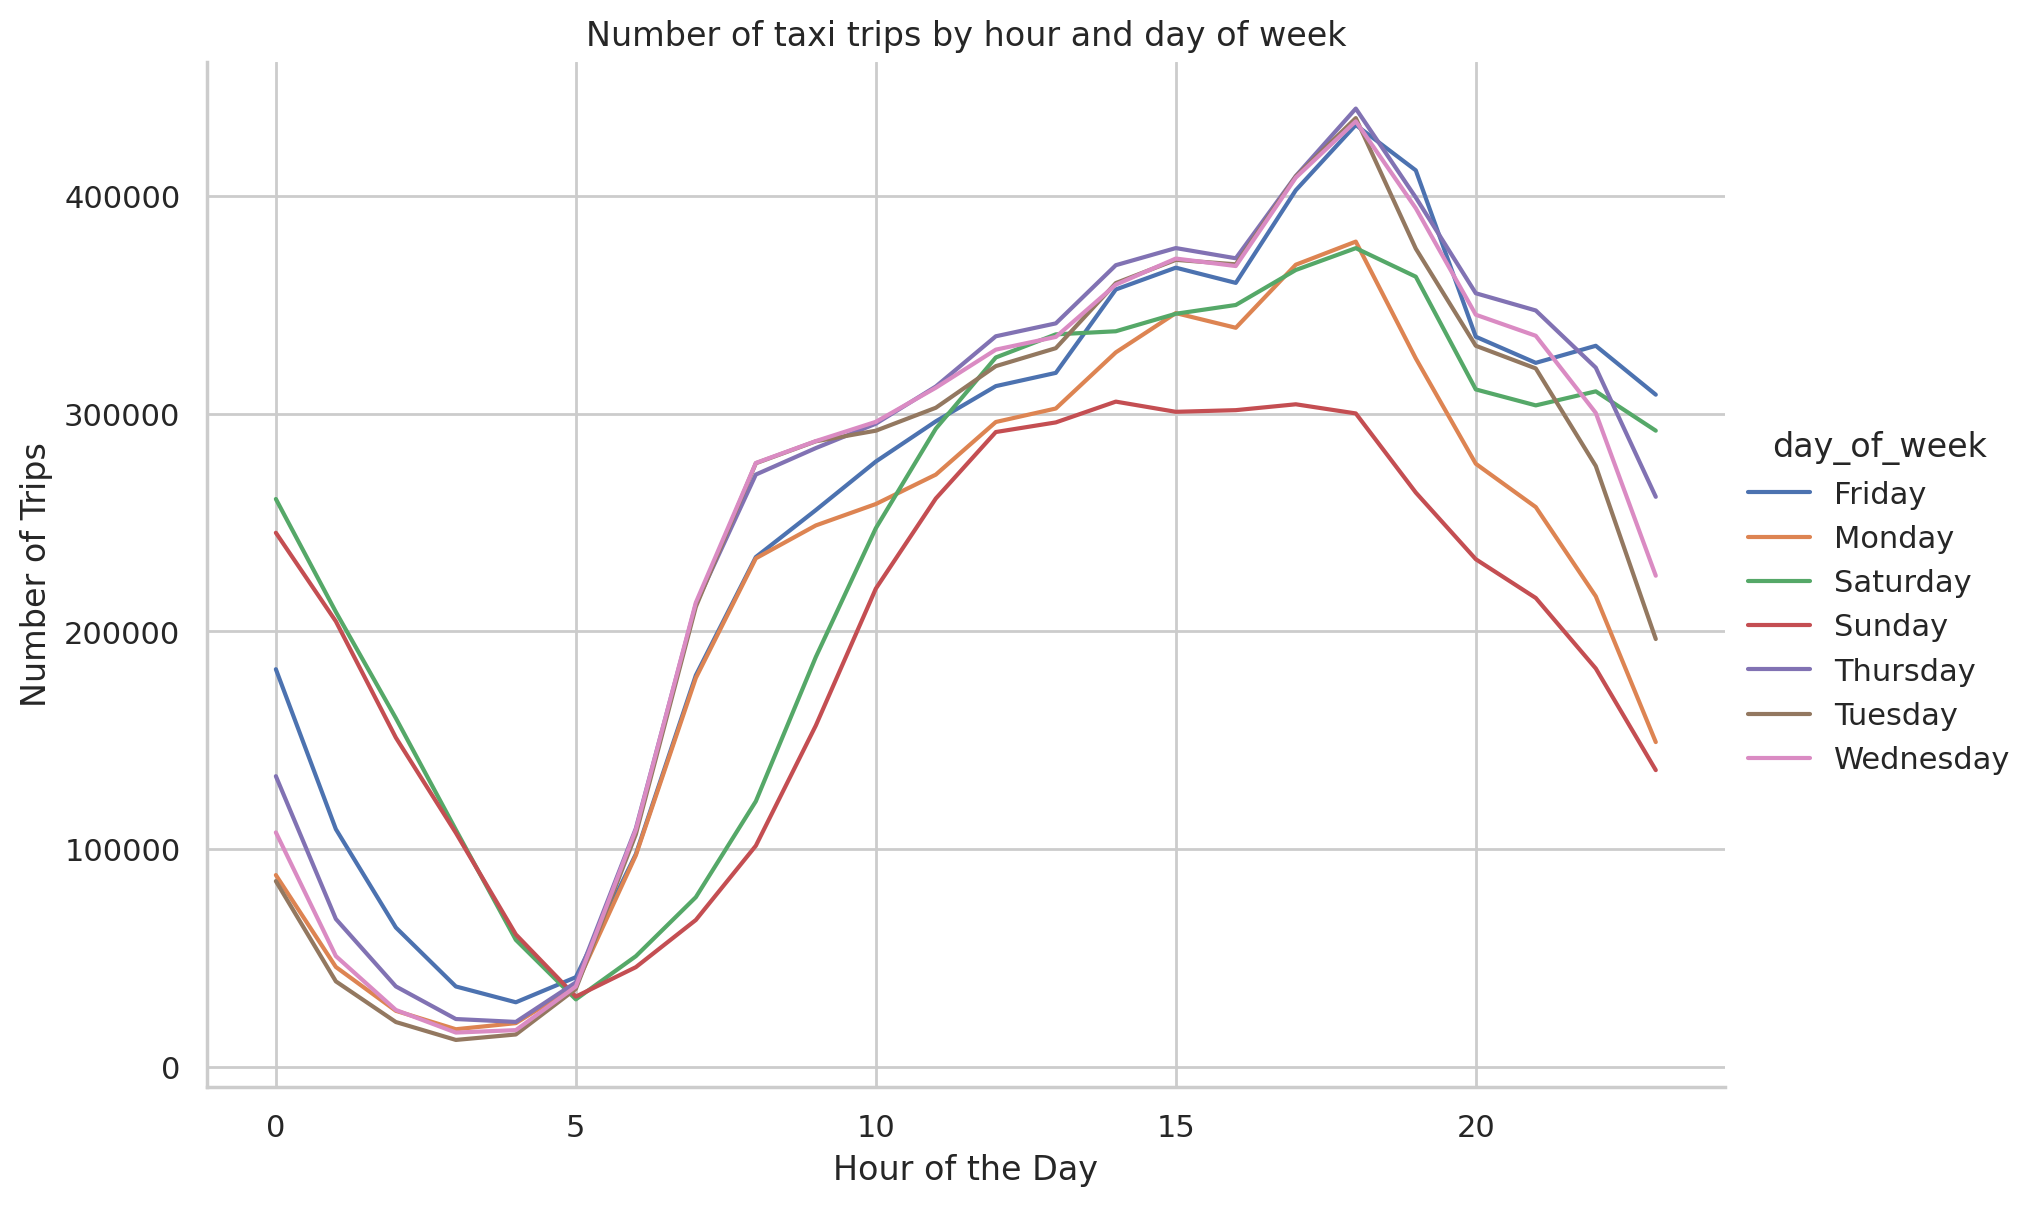

In [28]:
# number of trips vs hour for different days of week

# Count the number of trips for each hour and day of the week
hourly_counts = df.groupby(['day_of_week', 'pickup_hour']).size().reset_index(name='Trips')

# Set the plotting style
sns.set(style="whitegrid")

# Create the relplot
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='pickup_hour', y='Trips', hue='day_of_week', kind='line', data=hourly_counts, sort=True, height=6, aspect=1.5)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Number of Trips', title='Number of taxi trips by hour and day of week')

# Display the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

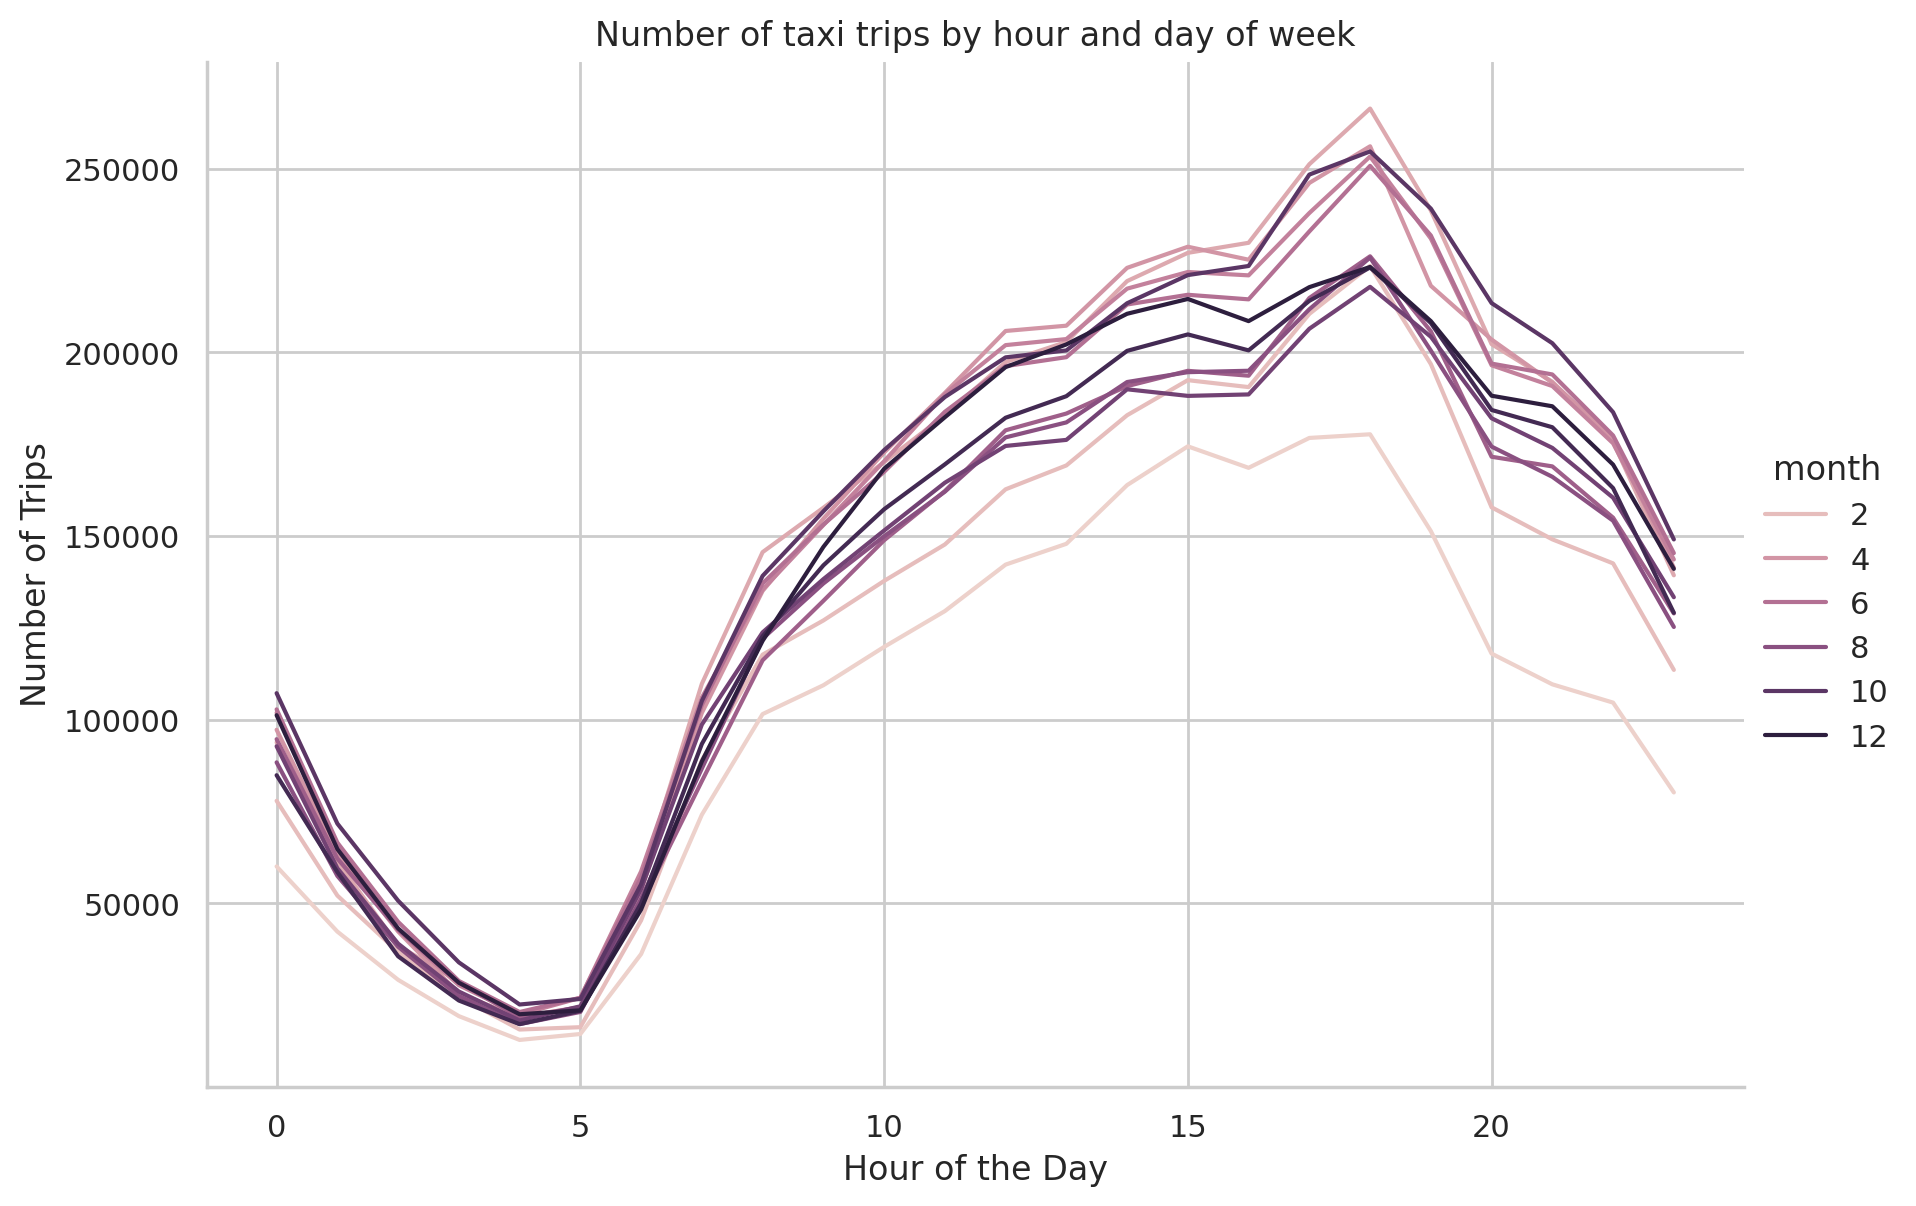

In [33]:
# number of trips vs hour for different months

# Count the number of trips for each hour and day of the week
hourly_counts = df.groupby(['month', 'pickup_hour']).size().reset_index(name='Trips')

# Set the plotting style
sns.set(style="whitegrid")

# Create the relplot
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='pickup_hour', y='Trips', hue='month', kind='line', data=hourly_counts, sort=True, height=6, aspect=1.5)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Number of Trips', title='Number of taxi trips by hour and day of week')

# Display the plot
plt.show()

In [22]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=69)
del df

In [29]:
# removing the outliers from the trip duration
# drop too short trips

df_train.drop(df_train[df_train['trip_duration'] < 120].index, axis=0, inplace=True)

In [30]:
df_train['trip_duration'].describe(percentiles=[.01, .015, .02, .05, .1, .2, .25, .5, .75, .8, .9, .95, .98, .99, .999])

count   27153360.000
mean        1061.211
std         2927.633
min          120.000
1%           154.000
1.5%         167.000
2%           179.000
5%           233.000
10%          299.000
20%          411.000
25%          464.000
50%          751.000
75%         1207.000
80%         1360.000
90%         1878.000
95%         2496.000
98%         3391.000
99%         4009.000
99.9%      83088.000
max       584823.000
Name: trip_duration, dtype: float64

In [31]:
# drop too long trips
df_train.drop(df_train[df_train['trip_duration'] > df_train['trip_duration'].quantile(0.99)].index, axis=0, inplace=True)

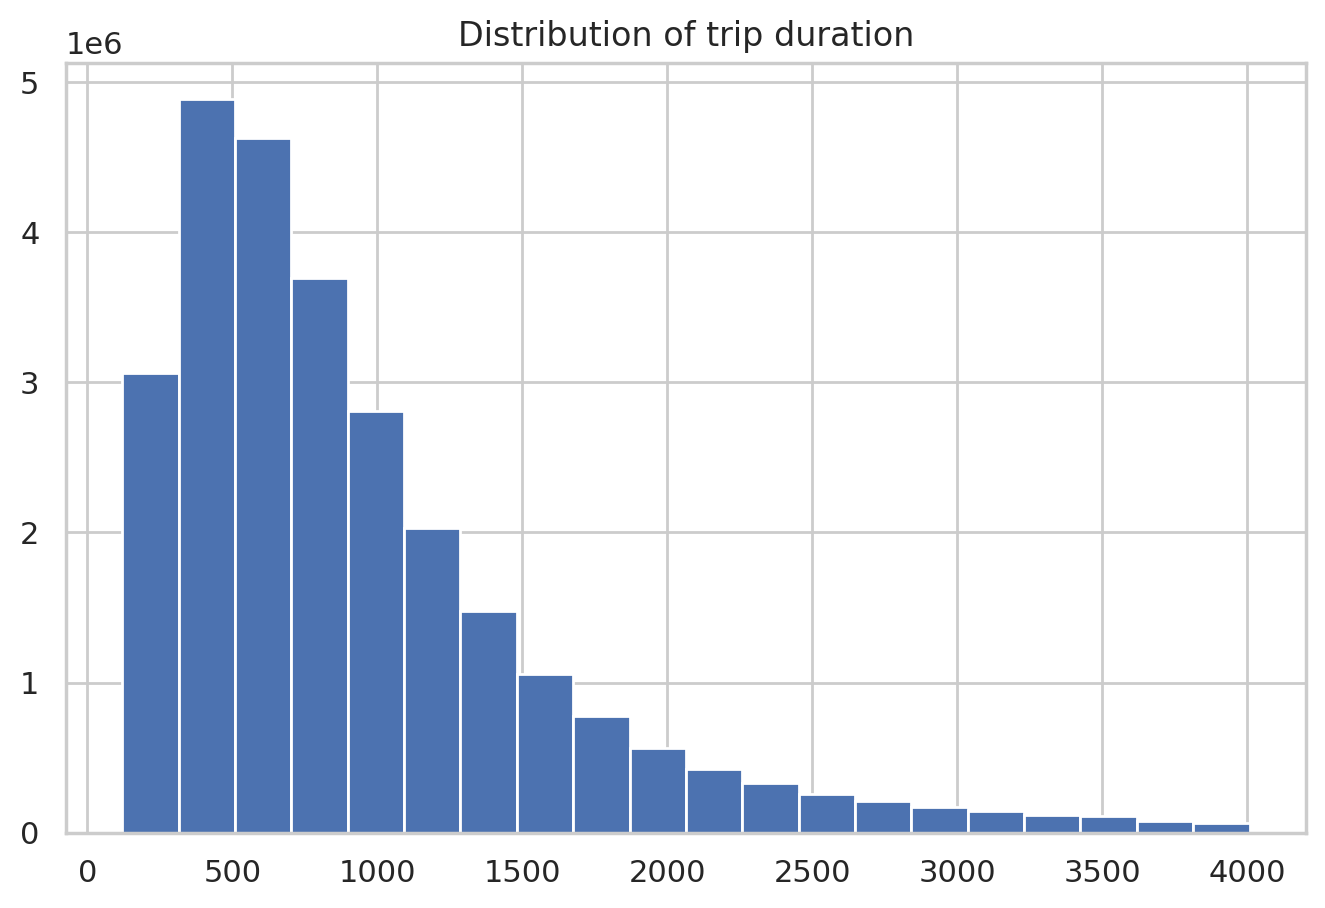

In [46]:
# trip duration histogram
plt.hist(df_train['trip_duration'], bins=20)
plt.title('Distribution of trip duration')
plt.show()

In [32]:
# log trip duration
df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])

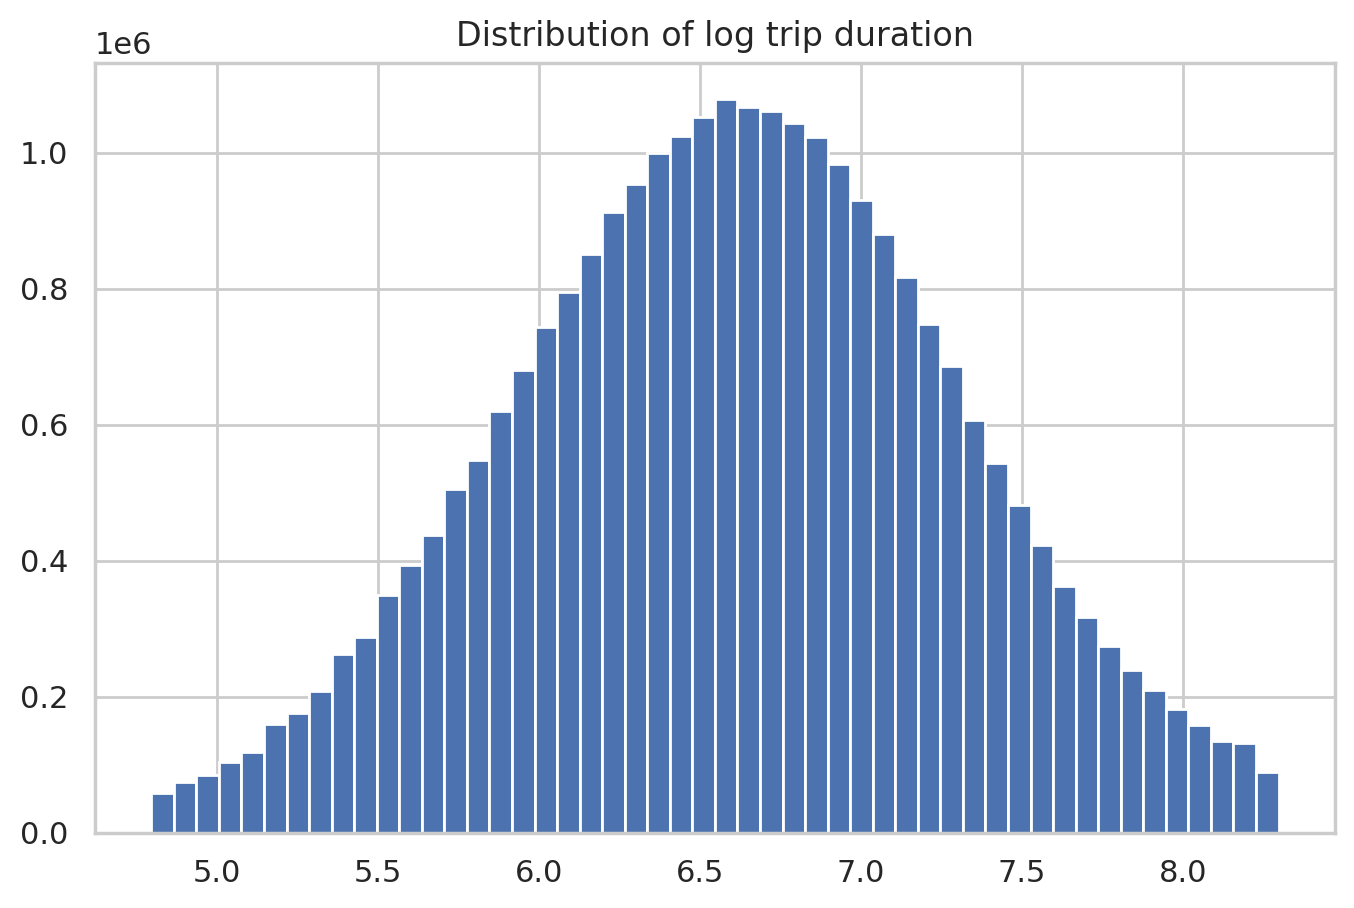

In [48]:
# log trip duration histogram
plt.hist(df_train['log_trip_duration'], bins=50)
plt.title('Distribution of log trip duration')
plt.show()

<Figure size 1200x600 with 0 Axes>

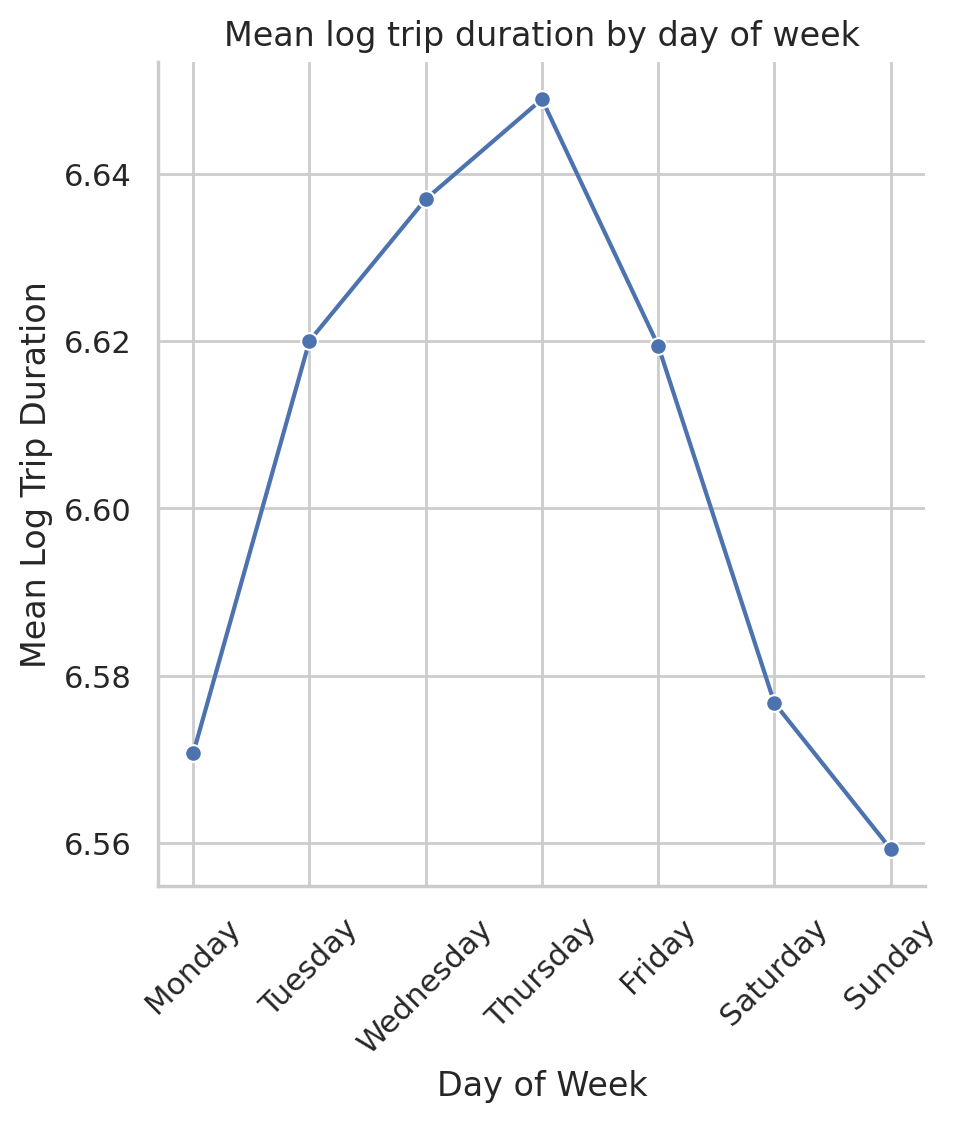

In [49]:
# mean log trip duration vs day of week

# Group by day of the week and calculate the mean log trip duration
mean_duration_by_day = df_train.groupby('day_of_week')['log_trip_duration'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create a relplot using seaborn
sns.set(style="whitegrid")  # Set the style if needed
plt.figure(figsize=(12, 6))  # Set the figure size if needed

# Use relplot to create the plot
plot = sns.relplot(x=mean_duration_by_day.index, y=mean_duration_by_day.values, kind='line', marker='o', sort=False)

# Set labels and title
plt.xlabel('Day of Week')
plt.ylabel('Mean Log Trip Duration')
plt.title('Mean log trip duration by day of week')

# Set the logical order for the days of the week
plot.set_xticklabels(rotation=45)

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

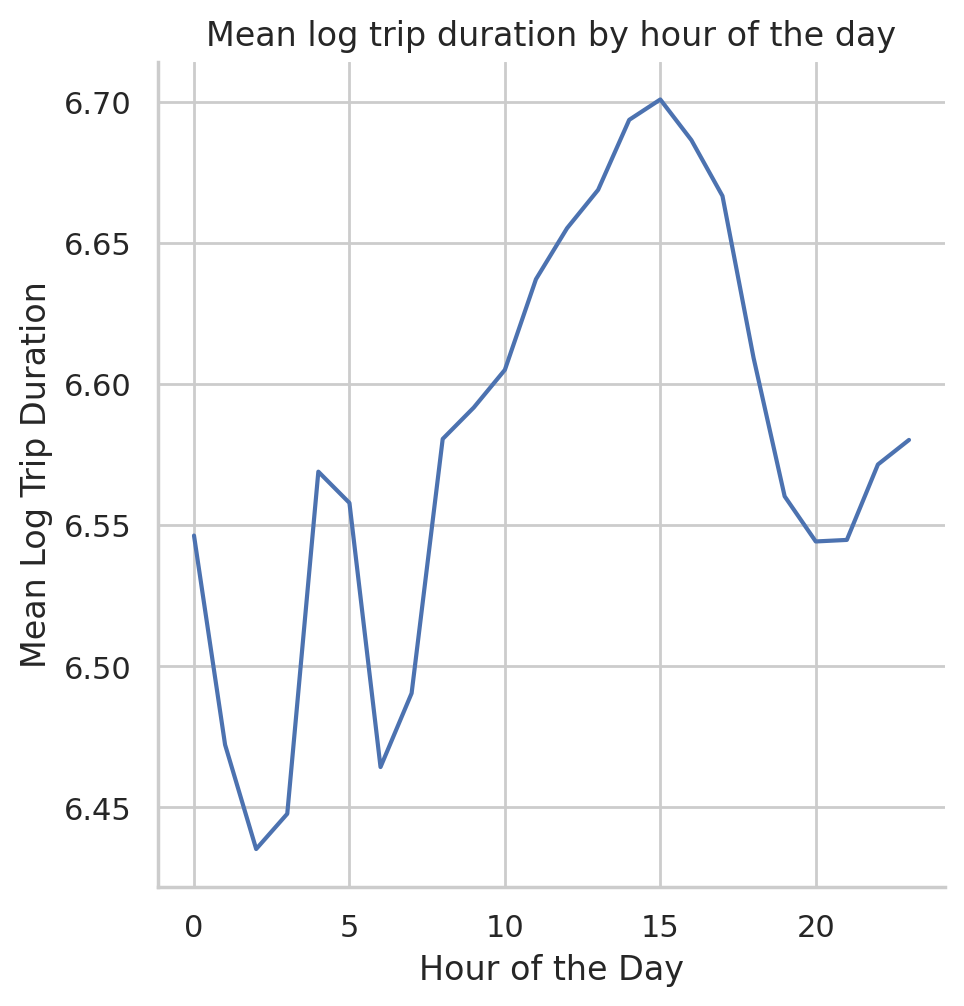

In [50]:
# mean log trip duration vs hour

# Create a new DataFrame with mean log trip duration for each hour of the day
mean_duration_by_hour = df_train.groupby('pickup_hour')['log_trip_duration'].mean().reset_index()

# Plot the data using sns.relplot()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='pickup_hour', y='log_trip_duration', kind='line', data=mean_duration_by_hour)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Mean Log Trip Duration', title='Mean log trip duration by hour of the day')

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

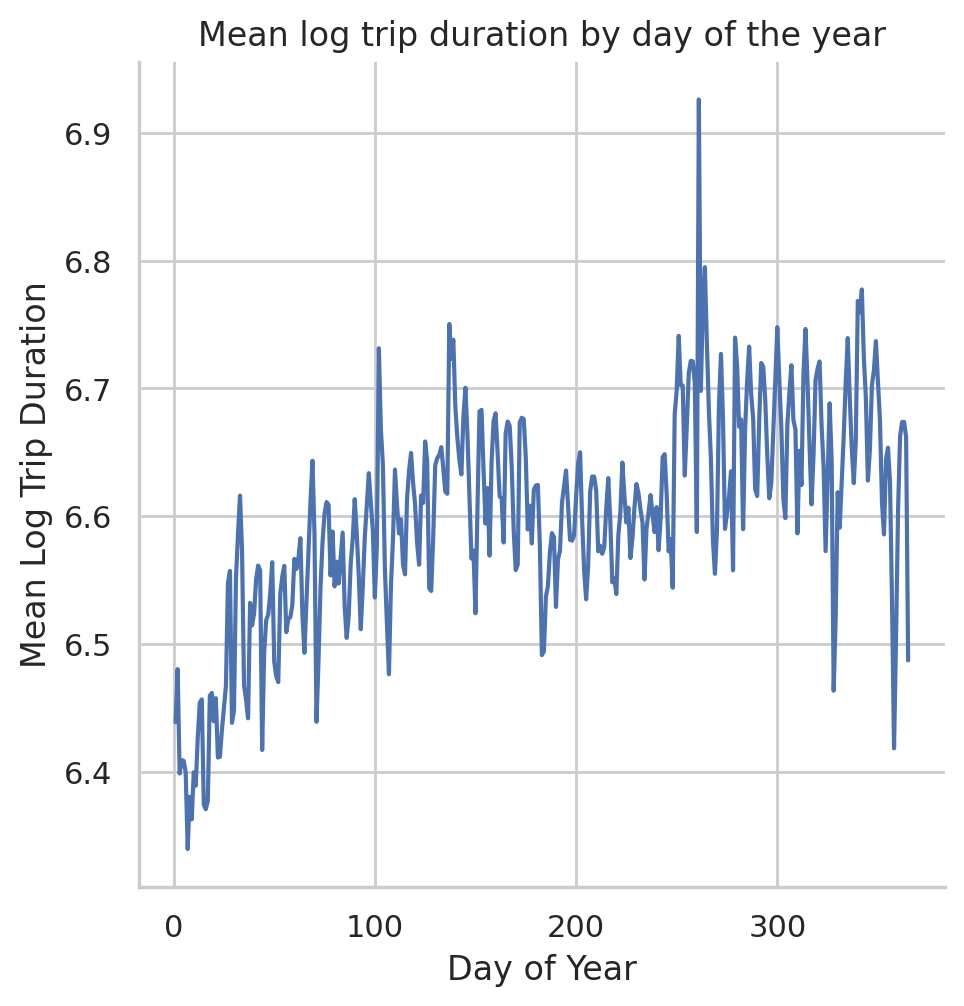

In [53]:
# mean log trip duration vs hour

# Create a new DataFrame with mean log trip duration for each hour of the day
mean_duration_by_hour = df_train.groupby('day_of_year')['log_trip_duration'].mean().reset_index()

# Plot the data using sns.relplot()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='day_of_year', y='log_trip_duration', kind='line', data=mean_duration_by_hour)

# Set plot labels and title
plot.set(xlabel='Day of Year', ylabel='Mean Log Trip Duration', title='Mean log trip duration by day of the year')

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

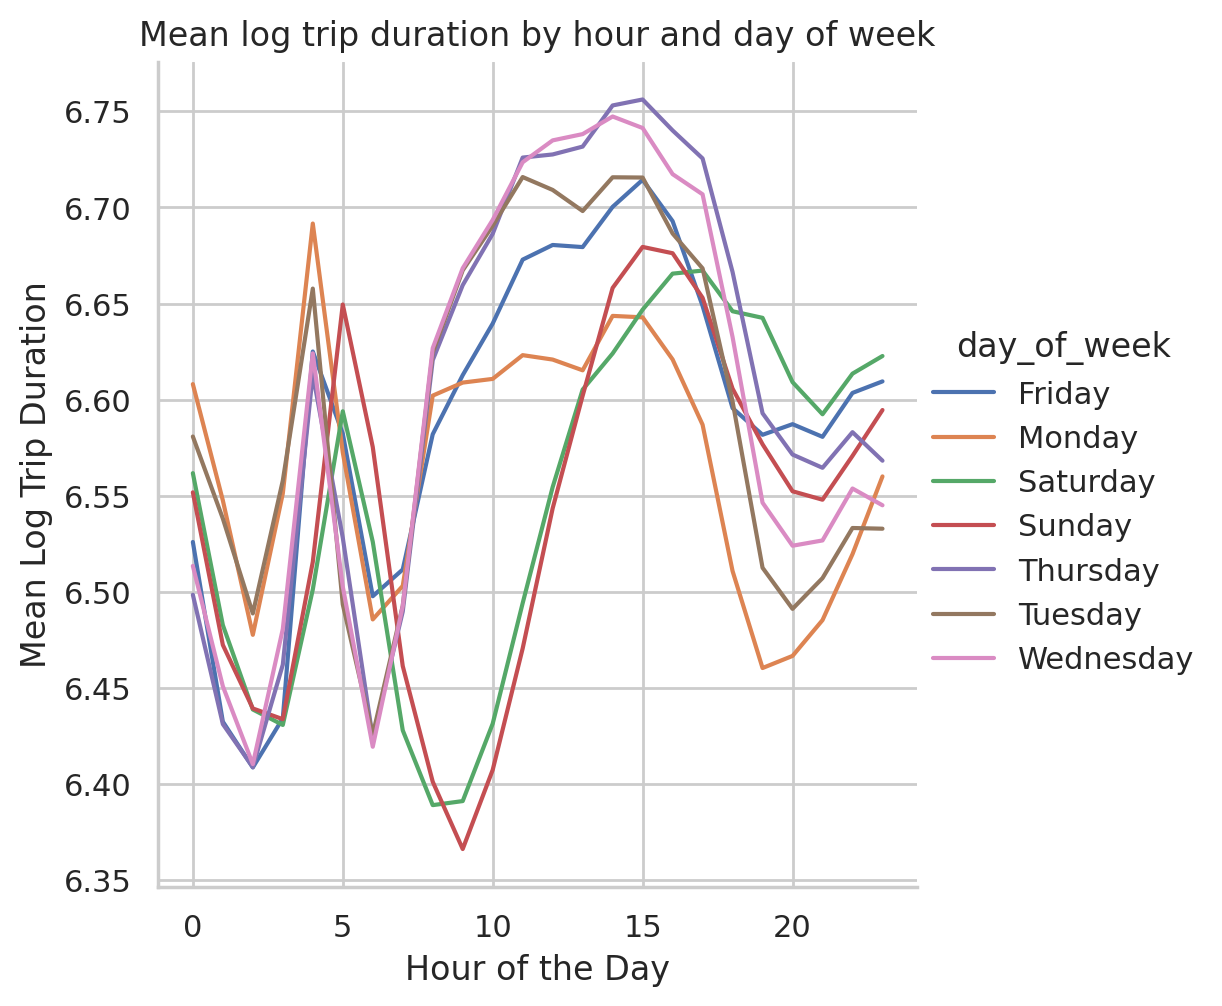

In [51]:
# mean log trip duration vs hour for different days of week

# Create a new DataFrame with mean log trip duration for each day of the week and hour of the day
mean_duration_by_hour_and_day = df_train.groupby(['day_of_week', 'pickup_hour'])['log_trip_duration'].mean().reset_index()

# Plot the data using sns.relplot() with 'hue' parameter
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plot = sns.relplot(x='pickup_hour', y='log_trip_duration', kind='line', hue='day_of_week', data=mean_duration_by_hour_and_day)

# Set plot labels and title
plot.set(xlabel='Hour of the Day', ylabel='Mean Log Trip Duration', title='Mean log trip duration by hour and day of week')

# Show the plot
plt.show()

In [55]:
df_train['log_trip_distance'] = np.log1p(df_train['trip_distance'])
df_train['log_trip_distance'].corr(df_train['log_trip_duration'])

0.8017735345754616

In [60]:
df_train['mean_velocity'] = df_train['trip_distance'] / df_train['trip_duration']

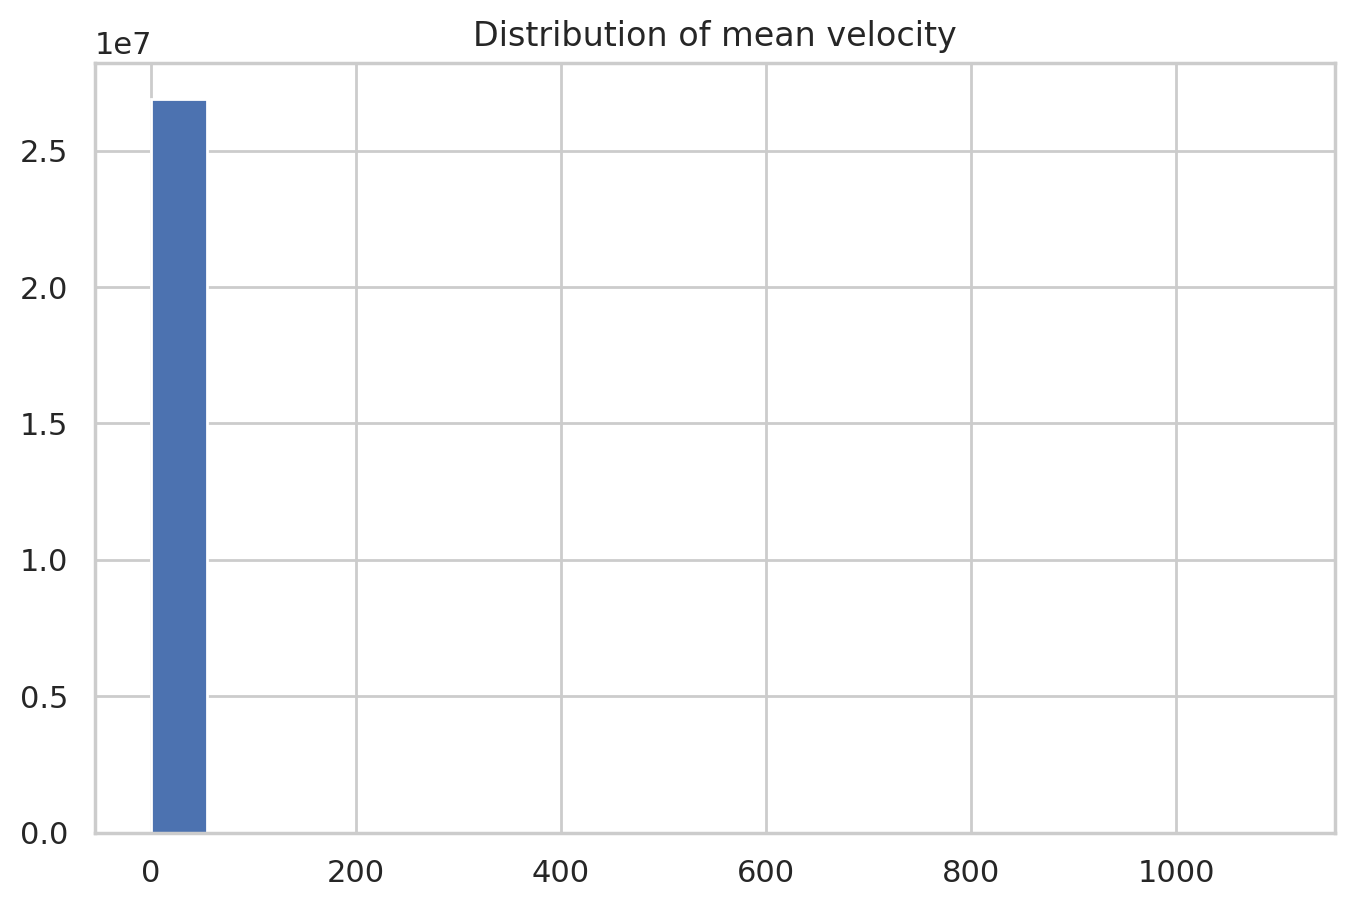

In [61]:
# mean velocity histogram
plt.hist(df_train['mean_velocity'], bins=20)
plt.title('Distribution of mean velocity')
plt.show()

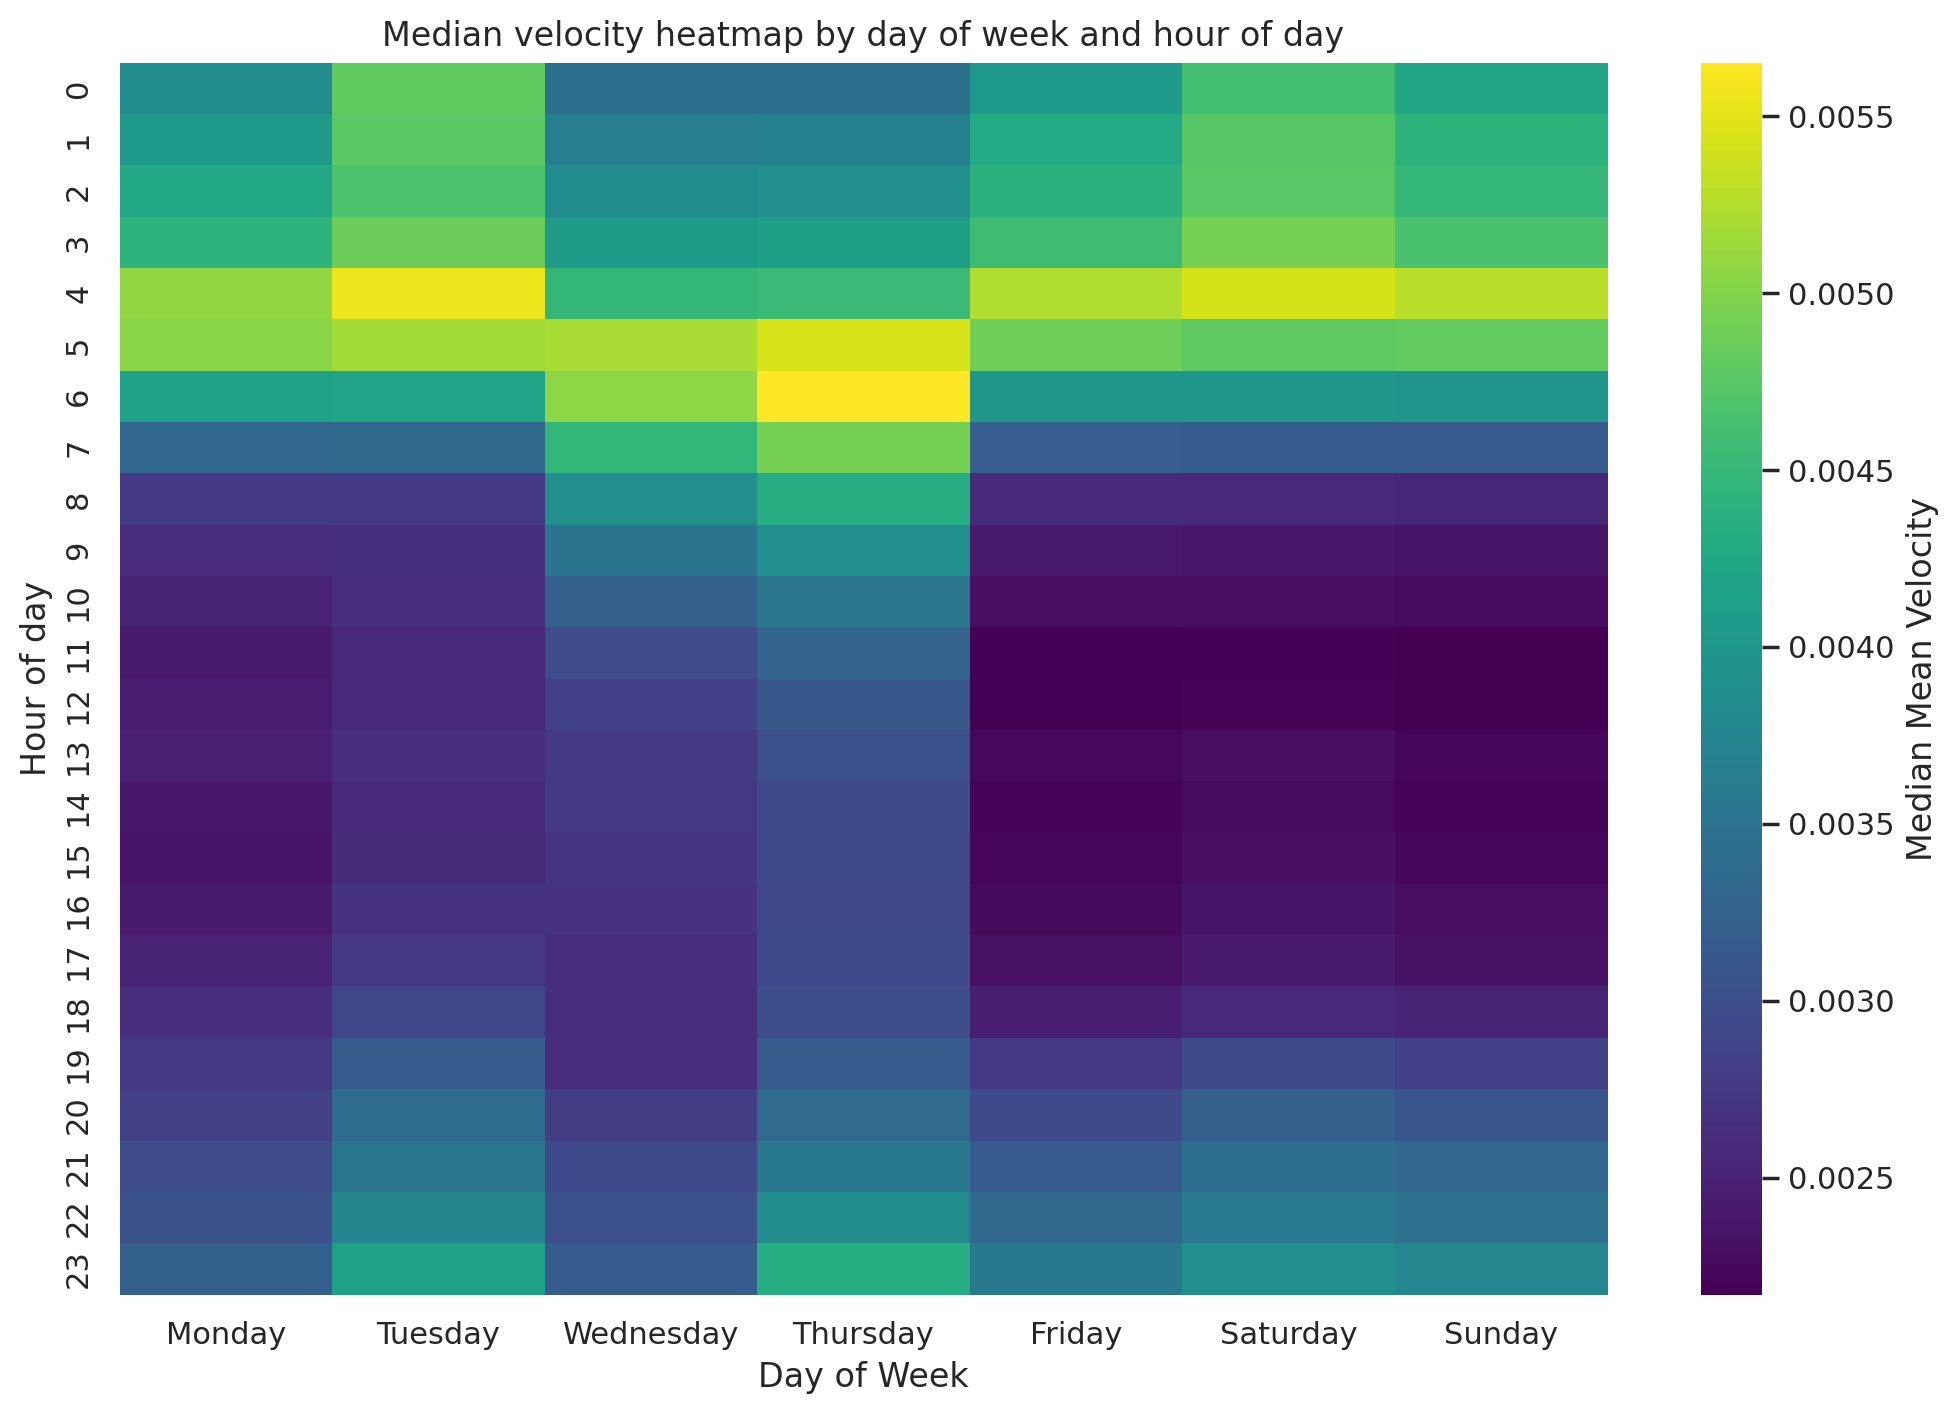

In [62]:
# heatmap of median velocity

# Calculate median of 'mean_velocity' for each combination of day_of_week and hour_of_day
heatmap_data = df_train.groupby(['day_of_week', 'pickup_hour'])['mean_velocity'].median().reset_index()

# Pivot the DataFrame for the heatmap
heatmap_data = heatmap_data.pivot_table(index='pickup_hour', columns='day_of_week', values='mean_velocity')

# Define the order of days of the week for proper sorting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the heatmap using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=days_order, cbar_kws={'label': 'Median Mean Velocity'})
plt.title('Median velocity heatmap by day of week and hour of day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of day')
plt.show()

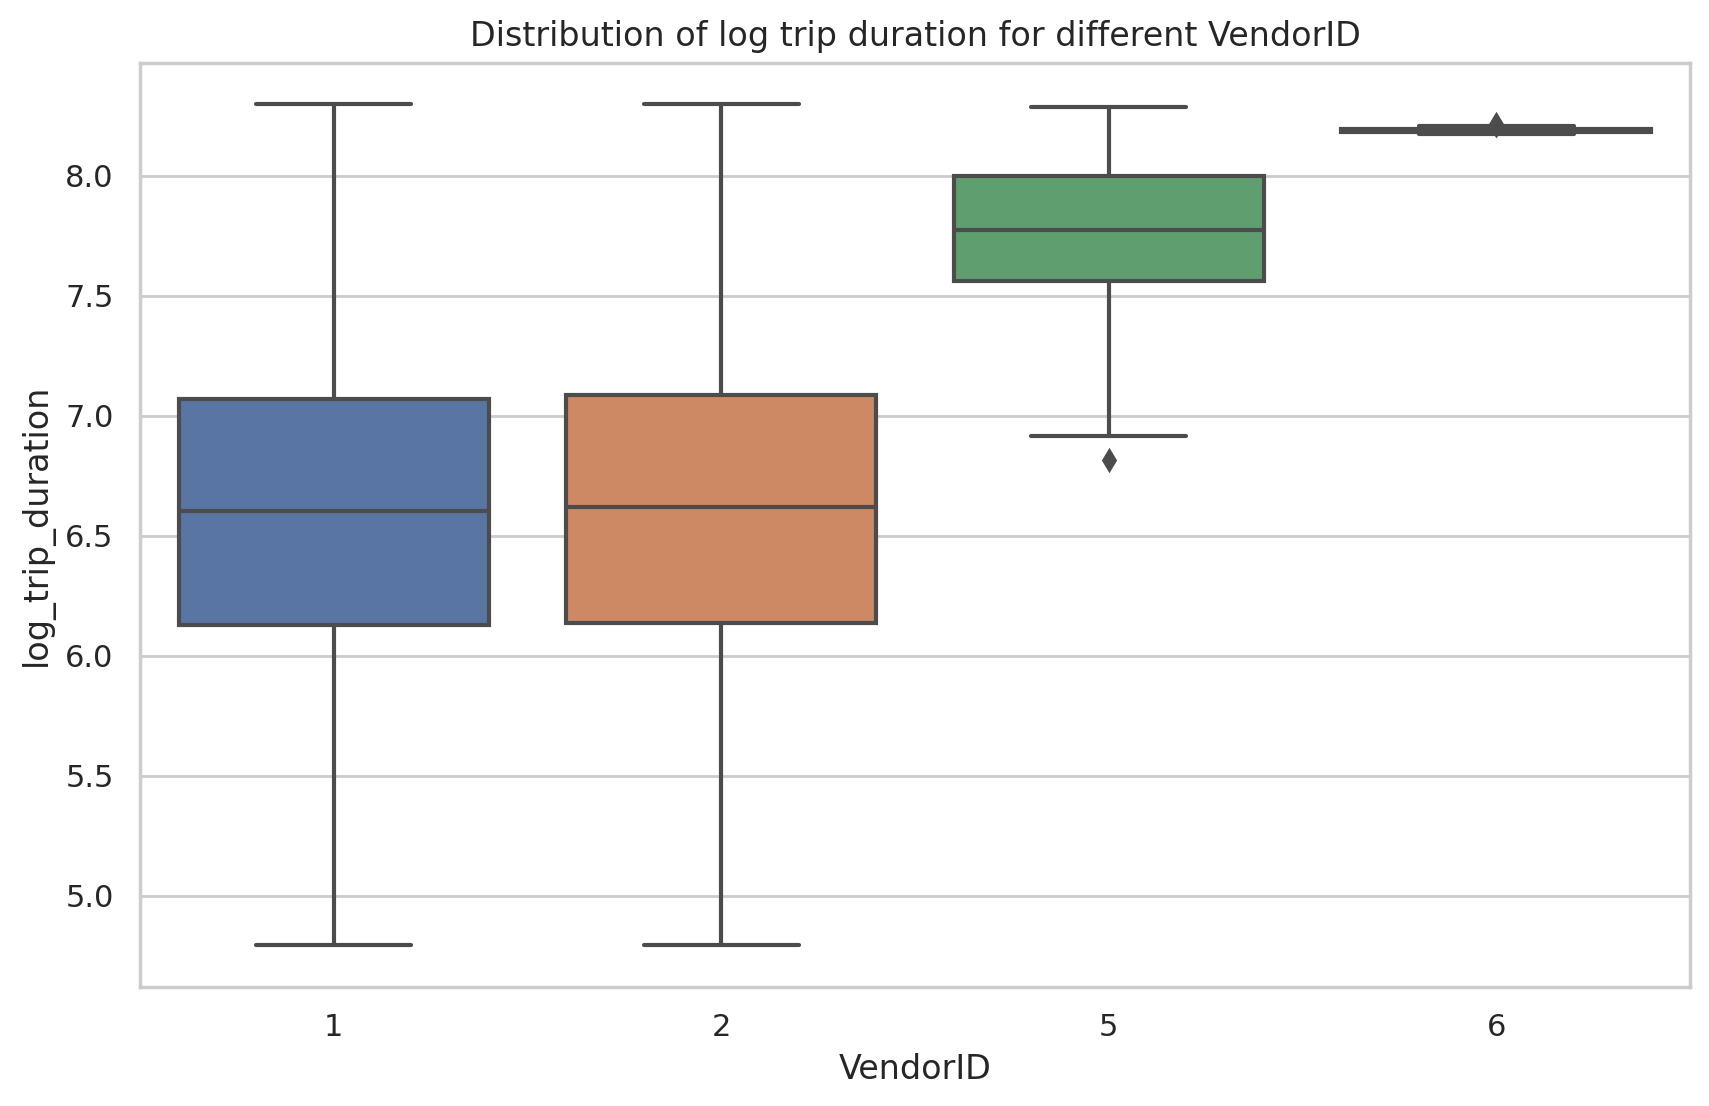

In [43]:
# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='VendorID', y='log_trip_duration', data=df_train)
plt.title('Distribution of log trip duration for different Vendor ID')
plt.xlabel('VendorID')
plt.ylabel('log_trip_duration')
plt.show()

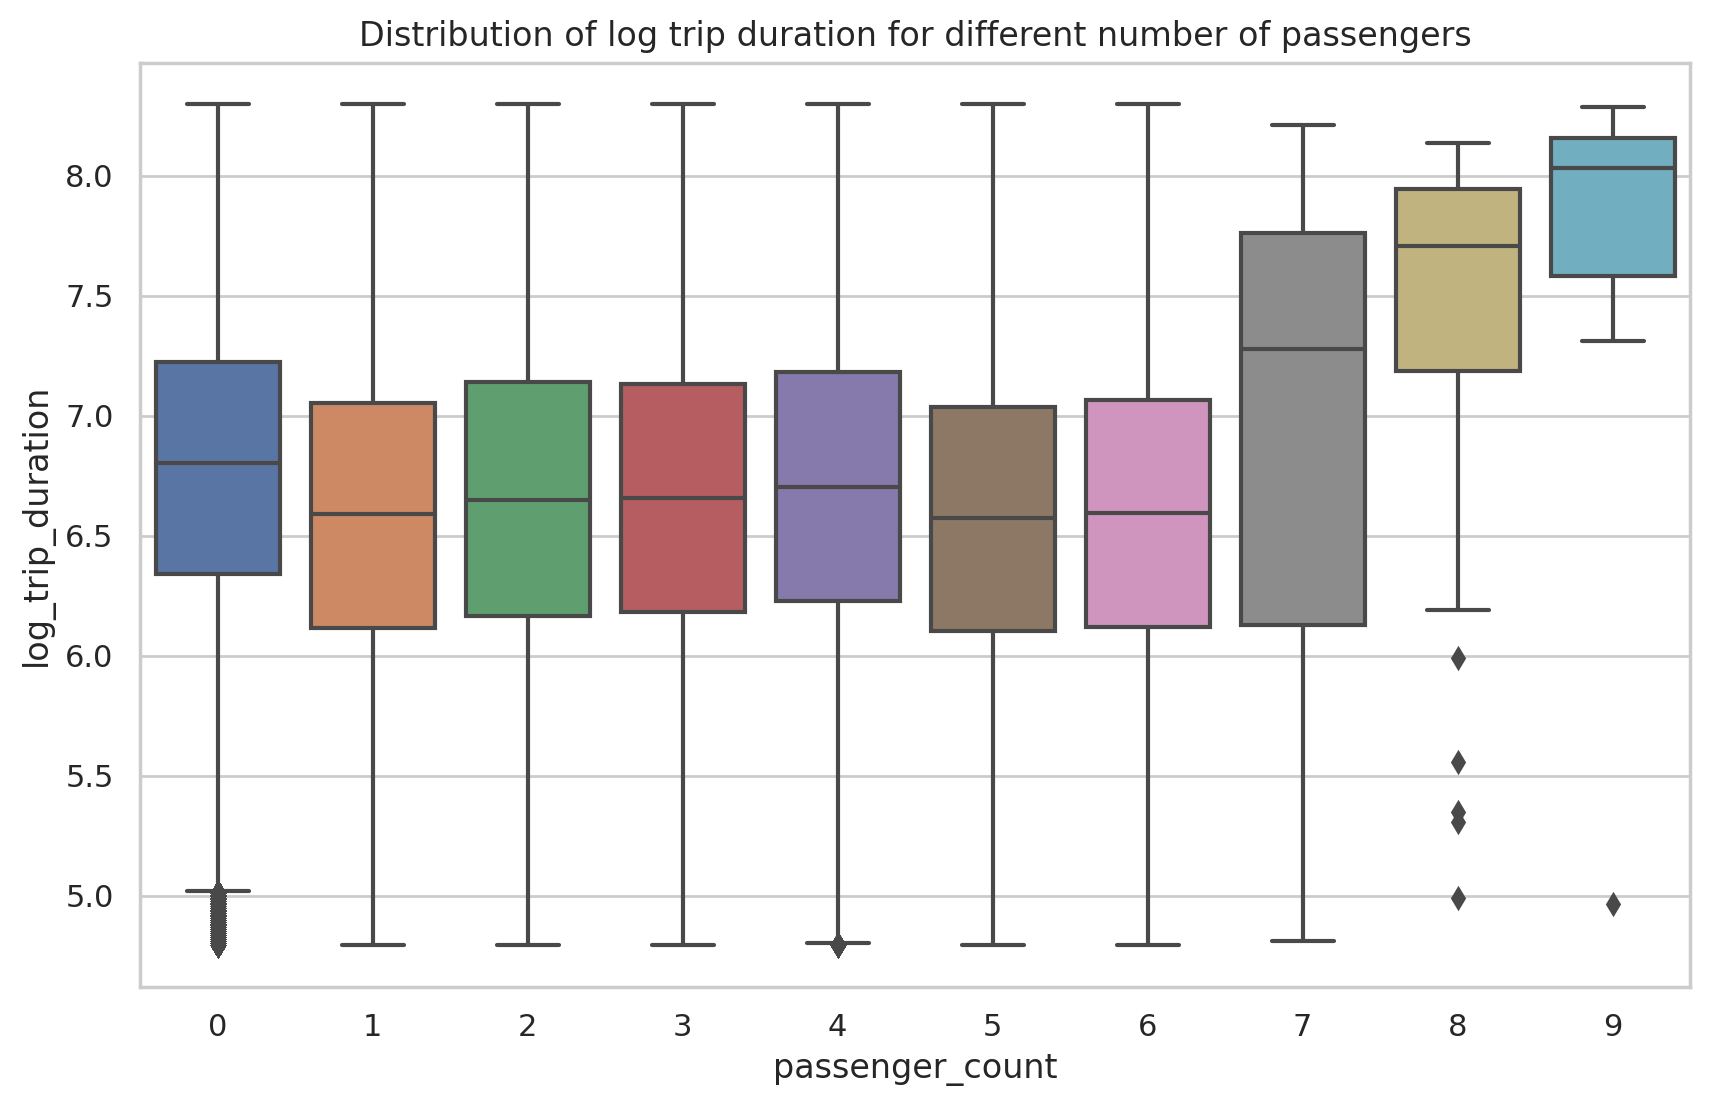

In [45]:
# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='log_trip_duration', data=df_train)
plt.title('Distribution of log trip duration for different number of passengers')
plt.xlabel('passenger_count')
plt.ylabel('log_trip_duration')
plt.show()

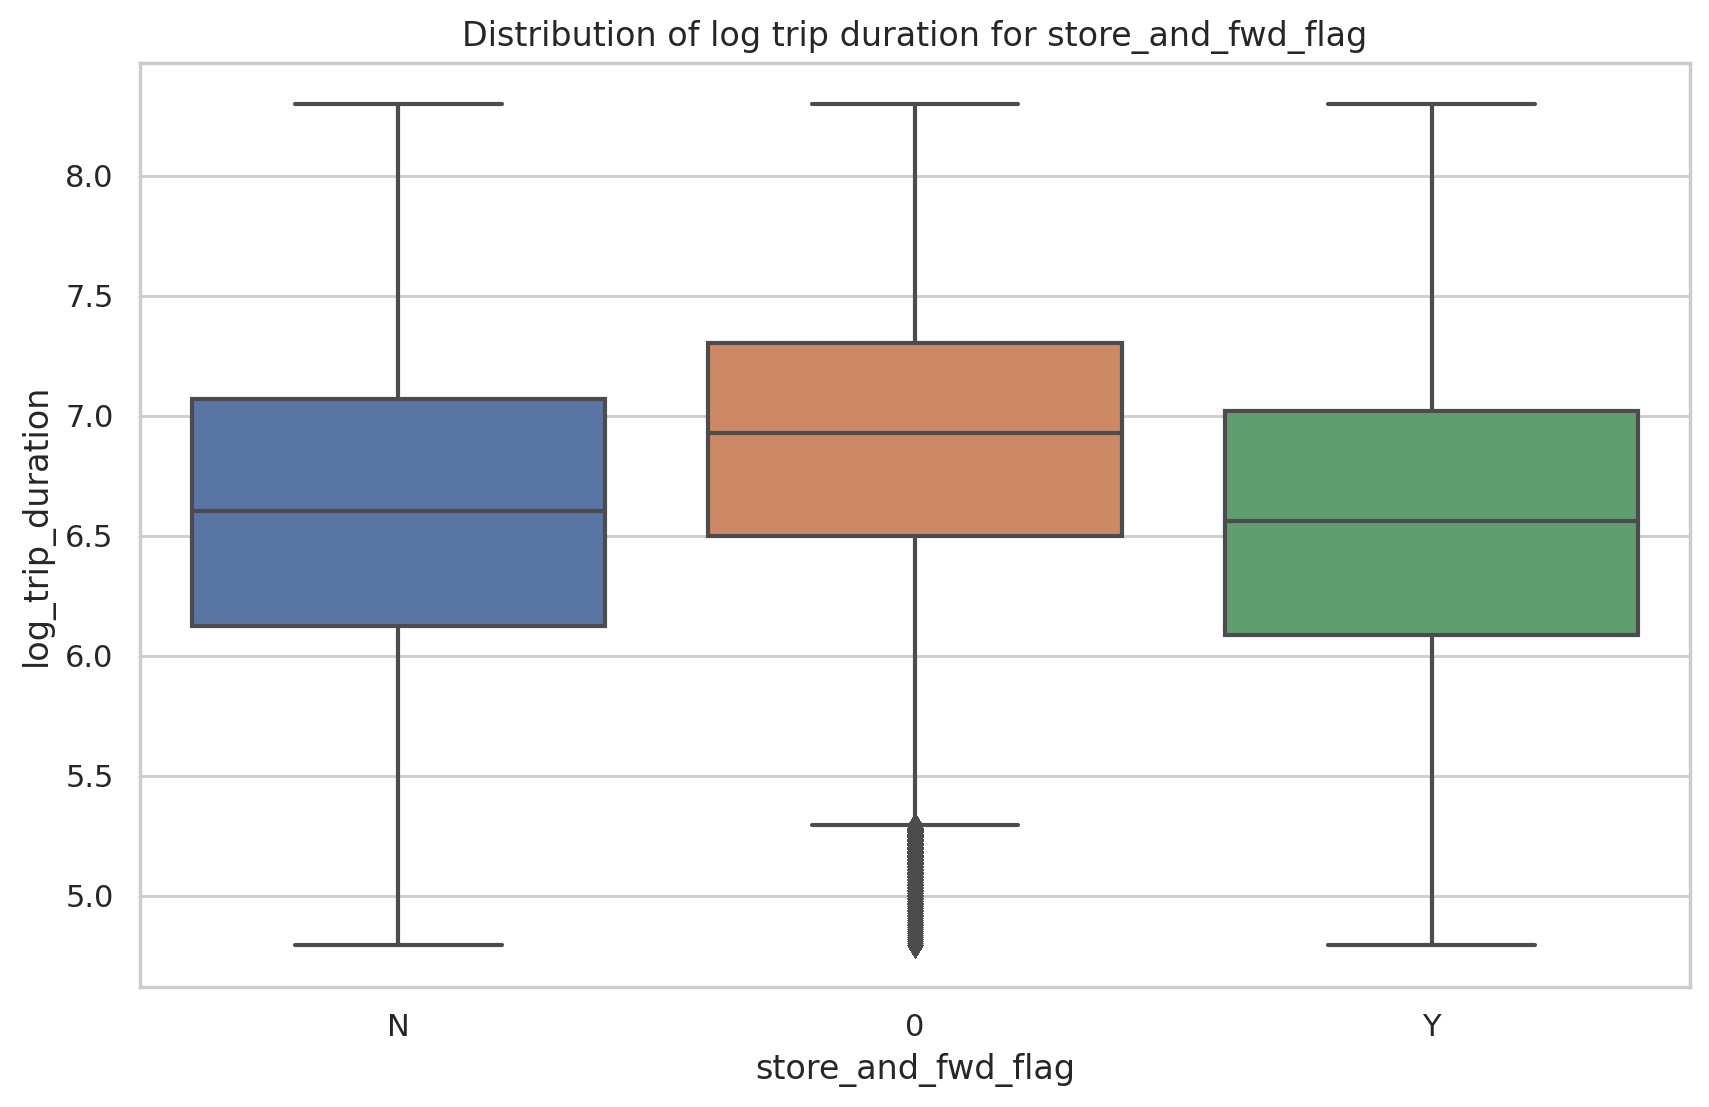

In [46]:
# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=df_train)
plt.title('Distribution of log trip duration for store_and_fwd_flag')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('log_trip_duration')
plt.show()